# UdepLog Neural-Logical Inference System

## 1. Visualization

In [1]:
import os
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display

def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    os.system('rm -rf ../data/tree.png')
    os.system('rm -rf ../data/tree.ps')
    cf.print_to_file('../data/tree.ps')
    cf.destroy()
    os.system('convert ../data/tree.ps ../data/tree.png')
    display(Image(filename='../data/tree.png'))

## 2. BERT Model for Pharaphrase

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

roberta_MRPC = "textattack/roberta-base-MRPC"
bert_MRPC = "bert-base-cased-finetuned-mrpc"

paraphraseTokenizer = AutoTokenizer.from_pretrained(roberta_MRPC)  
paraphraseModel = AutoModelForSequenceClassification.from_pretrained(roberta_MRPC)

Some weights of the model checkpoint at textattack/roberta-base-MRPC were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 3. UD Parser and RoBERTa Semantic Similarity

In [3]:
import json
from wordnet import *
from copy import deepcopy
from Udep2Mono.util import det_mark, det_type
from Udep2Mono.util import btree2list
from Udep2Mono.dependency_parse import tokenizer
from Udep2Mono.dependency_parse import dependency_parse
from Udep2Mono.binarization import BinaryDependencyTree
from Udep2Mono.polarization import PolarizationPipeline

2021-03-16 10:34:08 INFO: Loading these models for language: en (English):
| Processor | Package                  |
----------------------------------------
| tokenize  | ../model/e...ize/gum.pt  |
| pos       | ../model/en/pos/ewt.pt   |
| lemma     | ../model/en/lemma/gum.pt |
| depparse  | ../model/e...rse/gum.pt  |

2021-03-16 10:34:08 INFO: Use device: gpu
2021-03-16 10:34:08 INFO: Loading: tokenize
2021-03-16 10:34:09 INFO: Loading: pos
2021-03-16 10:34:10 INFO: Loading: lemma
2021-03-16 10:34:10 INFO: Loading: depparse
2021-03-16 10:34:10 INFO: Done loading processors!
2021-03-16 10:34:10 INFO: Loading these models for language: en (English):
| Processor | Package                 |
---------------------------------------
| tokenize  | ../model/e...ize/gum.pt |

2021-03-16 10:34:10 INFO: Use device: cpu
2021-03-16 10:34:10 INFO: Loading: tokenize
2021-03-16 10:34:10 INFO: Done loading processors!


In [4]:
from sentence_transformers import SentenceTransformer, util
sentenceTransformer = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")

def inference_sts(seq1s, seq2s, dist=False):
    embeddings1 = sentenceTransformer.encode(seq1s, convert_to_tensor=True)
    embeddings2 = sentenceTransformer.encode(seq2s, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    distance = torch.dist(embeddings1, embeddings2)
    if dist:
        return distance
    return cosine_scores[0][0]

## 4. Phrasal Monotonicity Inference

In [52]:
from pattern.en import pluralize, singularize
from copy import copy
import re
import torch

class PhrasalGenerator:
    def __init__(self):
        self.deptree = None
        self.annotated = None
        self.original = None
        self.kb = {}
        self.hypothesis = ""
        self.tree_log = []
        self.sent_log = []
        self.stop_critarion = False
        self.mod_at_left = [
            "advmod", "amod", "advmod:count", 
            "acl:relcl", "obl", 'obl:npmod', "det",
            "obl:tmod", "nmod", "nmod:npmod", 
            "nmod:poss", "nmod:tmod", "obl:npmod",
            "acl", "advcl", "xcomp", "ccomp", 
            'compound:ptr']
        self.mod_at_right = ["appos"] #"obj"
        self.mod_symmetric = ["conj", "compound"]
        self.mod_special = ["nsubj"]
        self.implicative = {
            "watching": 1
        }
        
        '''  
            "cop": self.generate_inherite, 
            "expl": self.generate_expl,
            "nummod": self.generate_nummod,
        '''

    def deptree_generate(self, tree, annotated, original):
        self.stop_critarion = False
        self.tree_log = []
        self.sent_log = []
        self.deptree = tree.copy()
        self.original = original  
        self.annotated = deepcopy(annotated)
        self.sentence = original
        self.generate(self.deptree)

    def generate(self, tree):
        if self.stop_critarion:
            return
        if not tree.is_tree:
            self.generate_default(tree)
        else:
            generation = self.get_generation_type(tree)
            #print(generation, tree.val)
            generation(tree)

    def get_generation_type(self, tree):
        if tree.val in self.mod_special:
            return self.generate_special

        disjunction = False
        if tree.val == "conj":
            disjunction |= self.search_dependency('or', tree.left)
            disjunction |= self.search_dependency('and', tree.left)
        
        left_mod = tree.left.mark == "+"
        left_mod = left_mod or tree.left.mark == "=" or disjunction
        left_mod = left_mod and tree.val in self.mod_at_left

        right_mod = tree.right.mark == "+" or tree.right.mark == "=" or disjunction 
        right_mod = right_mod and tree.val in self.mod_at_right

        sym_mod = tree.val in self.mod_symmetric and tree.left.mark == "+" and tree.right.mark == "+"

        if left_mod:
            return self.left_modifier_generate
        elif right_mod:
            return self.right_modifier_generate
        elif sym_mod:
            return self.symmetric_generate
        else:
            return self.generate_default

    def generate_special(self, tree):
        if tree.val == "nsubj":
            if tree.left.val == "who" and tree.right.val == "aux":
                self.left_modifier_generate(tree)

        self.generate(tree.left)
        self.generate(tree.right)

    def delete_cc(self, tree):
        if tree.val == "cc" and tree.left.val != "but":
            self.delete_modifier(tree, tree.right)

        if tree.is_tree:
            self.delete_cc(tree.left)
            self.delete_cc(tree.right)

    def delete_modifier(self, tree, modifier):
        tree.val = modifier.val
        tree.mark = modifier.mark
        tree.pos = modifier.pos
        tree.id = modifier.id
        
        tree.is_tree = modifier.is_tree
        tree.is_root = modifier.is_root

        tree.left = modifier.left
        tree.right = modifier.right

        self.delete_cc(tree)
        self.save_tree()

    def delete_left_modifier(self, tree):
        #print("Delet: ", tree.left.val)
        self.delete_modifier(tree, tree.right)

    def delete_right_modifier(self, tree):
        #print("Delet: ", tree.right.val)
        self.delete_modifier(tree, tree.left)

    def rollback(self, tree, backup):
        tree.val = backup.val
        tree.left = deepcopy(backup.left)
        tree.right = deepcopy(backup.right)
        tree.mark = backup.mark
        tree.pos = backup.pos
        tree.id = backup.id
        tree.is_tree = backup.is_tree
        tree.is_root = backup.is_root

    def symmetric_generate(self, tree):
        self.right_modifier_generate(tree)
        self.left_modifier_generate(tree)
        #self.delete_cc(tree)

    def right_modifier_generate(self, tree):
        left = tree.left
        right = tree.right
        backup = deepcopy(tree)

        self.delete_right_modifier(tree)
        self.save_tree()
        self.rollback(tree, backup)    
        
        self.generate(tree.left)
        self.generate(tree.right)

    def left_modifier_generate(self, tree):
        left = tree.left
        right = tree.right
        backup = deepcopy(tree)

        self.delete_left_modifier(tree)
        self.save_tree()
        self.rollback(tree, backup)   

        self.generate(tree.left)
        self.generate(tree.right)
    
    def return_last_leaf(self, tree):
        max_id = 0
        max_id_l = 0
        max_id_r = 0

        if tree.id != None:
            max_id = int(tree.id)
    
        if tree.left.is_tree:
            max_id_l = self.return_last_leaf(tree.left)
        else:
            max_id_l = tree.left.id

        if tree.right.is_tree:
            max_id_r = self.return_last_leaf(tree.right)
        else:
            max_id_r = tree.right.id

        return max(max_id, max(max_id_l, max_id_r))

    def return_first_leaf(self, tree):
        min_id = 100
        min_id_l = 100
        min_id_r = 100

        if tree.id != None:
            min_id = int(tree.id)
    
        if tree.left.is_tree:
            min_id_l = self.return_last_leaf(tree.left)
        else:
            min_id_l = tree.left.id

        if tree.right.is_tree:
            min_id_r = self.return_last_leaf(tree.right)
        else:
            min_id_r = tree.right.id

        return min(min_id, min(min_id_l, min_id_r))

    def add_modifier_sent(self, tree, modifier, direct=0): 
        sentence = deepcopy(self.sentence)
        if direct == 0:
            last_leaf = self.return_first_leaf(tree)
            sentence.insert(last_leaf-1, modifier)
        elif direct == 1:
            last_leaf = self.return_last_leaf(tree)
            sentence.insert(last_leaf, modifier)        

        self.remove_adjcent_duplicate(sentence)
        sentence = ' '.join(sentence)
        sentence = sentence.replace("-", " ")
        sentence = sentence.replace(" 's", "'s")

        if abs(len(sentence) - len(self.hypothesis)) < 15:
            re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', sentence, flags = re.I)
            sentence = sentence.strip() 
            
            if sentence.lower() == self.hypothesis.lower():
                self.stop_critarion = True
                self.sent_log.append((sentence, 1.0))
                return
                
            similarity = inference_sts([sentence], [self.hypothesis])
            if similarity > 0.90:
                self.sent_log.append((sentence, similarity))
            if similarity > 0.97:
                self.sent_log.append((sentence, similarity))
                self.stop_critarion = True

    def add_modifier_lexical(self, tree, modifier, head, word_id, direct=0):
        if direct == 0:
            generated = ' '. join([modifier, head])
        else:
            generated = ' '. join([head, modifier])
        
        sentence = deepcopy(self.sentence)
        diff = 0
        if word_id > len(sentence):
            diff = word_id - len(sentence)

        goal = word_id-1-diff
        sentence[goal] = "DEL"
        sentence[goal:goal] = generated.split(' ')

        if abs(len(sentence) - len(self.hypothesis.split(' '))) < 7:
            self.remove_adjcent_duplicate(sentence)
            sentence = ' '.join(sentence)
            sentence = sentence.replace("DEL ", "")
            sentence = sentence.replace("DEL", "")
            sentence = sentence.replace("-", " ")
            sentence = sentence.replace(" 's", "'s")
            re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', sentence, flags = re.I)
            sentence = sentence.strip()

            if sentence.lower() == self.hypothesis.lower():
                self.stop_critarion = True
                self.sent_log.append((sentence, 1.0))
                return
            
            similarity = inference_sts([sentence], [self.hypothesis])
            if similarity > 0.9:
                self.sent_log.append((sentence, similarity))
            if similarity > 0.97:
                self.sent_log.append((sentence, similarity))
                self.stop_critarion = True

    def generate_default(self, tree):
        VP_rel = {
            "aux":1, 
            "obj":1, 
            "obl":1, 
            "xcomp":1, 
            "ccomp":1,
            "aux:pass":1, 
            "obl:tmod":1, 
            "obl:npmod":1
        }

        VP_mod = {
            "advcl":1, 
            "xcomp":1, 
            "ccomp":1,
            "obj":1, 
            "advmod":1, 
            "obl":1, 
            "obl:tmod":1,
            "obl:nmod":1, 
            "parataxis":1, 
            "conj":1
        }

        NP_rel = {
            "amod":1,
            "compound":1,
            "det":1,
            "mark":1,
            "nmod:poss":1,
            "flat":1,
            "acl:relcl":1,
            "acl":1,
            "nmod":1
        }

        NP_mod = {
            "amod":1,
            "compound":1,
            "det":1,
            "mark":1,
            "nmod:poss":1,
            "flat":1,
        }

        if tree.pos is not None:
            if ("NN" in tree.pos or "JJ" in tree.pos) and tree.mark == "-":
                for rel in ["amod", "compound", "det", "mark", "nmod:poss", "flat", "conj", "nummod"]:
                    if rel in self.kb:
                        for phrase in self.kb[rel]:
                            if phrase['head'] == tree.val:
                                self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id)
                for rel in ["amod", "acl:relcl", "compound", "acl", "nmod"]:
                    if rel in self.kb:
                        for phrase in self.kb[rel]:
                            if phrase['head'] == tree.val:
                                self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id, 1)
                
            elif "VB" in tree.pos and tree.mark == "-":
                for rel in ["advmod"]:
                    if rel in self.kb:
                        for phrase in self.kb[rel]:
                            self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id)
                            self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id, 1)

        elif VP_rel.get(tree.val, 0) and tree.mark == "-":
            for rel in VP_mod:
                if rel in self.kb:
                    for phrase in self.kb[rel]:
                        self.add_modifier_sent(tree, phrase['mod'], direct=1)

        elif NP_rel.get(tree.val, 0) and tree.mark == "-":
            for rel in NP_mod:
                if rel in self.kb:
                    for phrase in self.kb[rel]:
                        self.add_modifier_sent(tree, phrase['mod'], direct=0)
        
        if VP_rel.get(tree.val, 0) and tree.right.val == "watching":
            self.save_tree(tree=tree.left)
        if tree.is_tree:
            self.generate(tree.left)
            self.generate(tree.right)  

    def save_tree(self, tree=None):
        if tree is None:
            leaves = self.deptree.sorted_leaves().popkeys()
            tree_copy = self.deptree.copy()
        else:
            leaves = tree.sorted_leaves().popkeys()
            tree_copy = tree.copy()
        
        sentence = ' '.join([x[0] for x in leaves])
        sentence = sentence.replace("-", " ")
        if sentence.lower() == self.hypothesis.lower():
            self.tree_log = []
            self.stop_critarion = True
            self.tree_log.append((tree_copy, sentence, 1.0))
            return
        
        similarity = inference_sts([sentence], [self.hypothesis])
        #print(sentence, similarity)
        if similarity > 0.8:
            self.tree_log.append((tree_copy, sentence, similarity))
        if similarity > 0.97:
            self.tree_log = []
            self.tree_log.append((tree_copy, sentence, similarity))
            self.stop_critarion = True
    
    def remove_adjcent_duplicate(self, string):
        to_remove = -1
        for i in range(len(string)-1):
            if string[i] == string[i+1]:
                to_remove = i
        if to_remove > -1:
            del string[to_remove]

    def search_dependency(self, deprel, tree):
        if tree.val == deprel:
            return True
        else:
            right = tree.right
            left = tree.left

            left_found = False
            right_found = False

            if right is not None:
                right_found = self.search_dependency(deprel, right)

            if left is not None:
                left_found = self.search_dependency(deprel, left)

            return left_found or right_found
    
    def Diff(self, li1, li2):
        return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))    
    
    def preprocess(self, sentence):
        preprocessed = sentence.replace(".", "").replace("!", "").replace("?", "")
        preprocessed = preprocessed.replace("can't", "can not")
        preprocessed = preprocessed.replace("couldn't", "could not")
        preprocessed = preprocessed.replace("don't", "do not")
        preprocessed = preprocessed.replace("doesn't", "does not")
        preprocessed = preprocessed.replace("isn't", "is not")
        preprocessed = preprocessed.replace("won't", "will not")
        preprocessed = preprocessed.replace("wasn't", "was not")
        preprocessed = preprocessed.replace("weren't", "were not")
        preprocessed = preprocessed.replace("didn't", "did not")
        preprocessed = preprocessed.replace("aren't", "are not")
        preprocessed = preprocessed.replace("it's", "it is")
        preprocessed = preprocessed.replace("wouldn't", "would not")
        preprocessed = preprocessed.replace("There's", "There is")
        return preprocessed

In [6]:
modifier_relation = {
    "NN": ["amod", "nmod", "acl:relcl", "fixed", "compound", "det", "nmod:poss", "conj", "nummod"],
    "VB": ["advmod", "acl", "obl", "xcomp", "advcl", "obl:tmod", "parataxis", "obj","ccomp"]
}

def down_right(tree):
    if(tree.right == None):
        return tree
    return down_right(tree.right)

def down_left(tree):
    if(tree.left == None):
        return tree
    return down_left(tree.left)

def collect_modifiers(tree, sent_set, mod_type="NN"):
    leaves = []
    if tree.is_tree:
        if tree.val in ["mark", "case", "compound", "flat", "nmod"]:
            leaves.append(
                (list(tree.right.sorted_leaves().popkeys()),
                down_right(tree.left).val)
            )
        if tree.val in modifier_relation[mod_type]:
            leaves.append(
                (list(tree.left.sorted_leaves().popkeys()),
                down_right(tree.right).val)
            )

        for leave in leaves:
            if len(leave) > 0 and len(leave) < 10:
                head = leave[1]
                modifier = ' '.join([x[0] for x in leave[0]])
                if tree.val in sent_set:
                    sent_set[tree.val].append({'head': head,'mod': modifier})
                else:
                    sent_set[tree.val] = [{'head': head,'mod': modifier}]
        
        collect_modifiers(tree.left, sent_set, mod_type)
        collect_modifiers(tree.right, sent_set, mod_type)



Init Premise: A family is watching a little boy who is hitting a baseball

Hypothesis: A little boy who is hitting a baseball
{   'acl:relcl': [{'head': 'boy', 'mod': 'who is hitting a baseball'}],
    'amod': [{'head': 'boy', 'mod': 'little'}],
    'det': [{'head': 'boy', 'mod': 'A'}, {'head': 'baseball', 'mod': 'a'}],
    'obj': [{'head': 'hitting', 'mod': 'a baseball'}]}


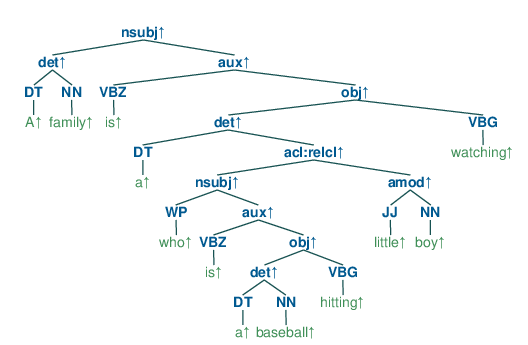

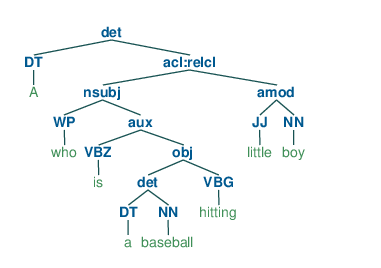

('a little boy who is hitting a baseball', 1.0)

True


In [53]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

up = ["A family is watching a little boy who is hitting a baseball."]
up_h = ["A little boy who is hitting a baseball."]

annotations = []
phrasalGenerator = PhrasalGenerator()
pipeline = PolarizationPipeline(verbose=0)
for i in range(len(up)):
    premise = up[i]
    hypothesis = up_h[i]
    premise = phrasalGenerator.preprocess(premise)
    hypothesis = phrasalGenerator.preprocess(hypothesis)

    tokenized = tokenizer(premise).sentences[0].words
    tokens = [tok.text for tok in tokenized]

    print("\n====================================")
    print("\nInit Premise: " + premise)
    print("\nHypothesis: " + hypothesis)

    h_parsed, replaced = dependency_parse(hypothesis, parser="stanza")
    h_tree, _ = pipeline.run_binarization(h_parsed, hypothesis, {})
    pipeline.modify_replacement(h_tree, replaced)
    phrases = {} 
    collect_modifiers(h_tree, phrases, mod_type="NN")
    collect_modifiers(h_tree, phrases, mod_type="VB")
    annotation = pipeline.single_polarization(premise)
    
    phrasalGenerator.kb = phrases
    phrasalGenerator.hypothesis = hypothesis.replace(',', '')
    pp.pprint(phrasalGenerator.kb)
    
    polarized = pipeline.postprocess(annotation['polarized_tree'], {})
    btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btreeViz) 

    polarized = pipeline.postprocess(h_tree, {})
    btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btreeViz)
    
    phrasalGenerator.deptree_generate(
        annotation['polarized_tree'], 
        annotation['annotated'], tokens)

    for gen_tree in phrasalGenerator.tree_log:
        #leaves = gen_tree[0].sorted_leaves().popkeys()
        #sentence = ' '.join([x[0] for x in leaves])
        print((gen_tree[1], gen_tree[2]))

    print(*phrasalGenerator.sent_log, sep="\n")
    print(phrasalGenerator.stop_critarion)

## 5. Lexical Monotonicity Inference

In [7]:
class LexicalGenerator:
    def __init__(self):
        self.deptree = None
        self.hypothesis = ""
        self.tree_log = []
        self.polar_log = []
        self.replacement_log = []
        self.stop_critarion = False
        self.key_tokens = [
            'NN','NNS','NNP','NNPS','VBD',
            'VBG','VBN','VBZ','VB']

        self.propers = ["someone", "something", "somewhere"]

        self.quantifiers = {}
        with open('quantifier.json', 'r') as quants:
             quantifier_data = json.load(quants)
             for quantifier in quantifier_data:
                 self.quantifiers[quantifier['word']] = quantifier

    def deptree_generate(self, tree):
        self.stop_critarion = False
        self.deptree = tree
        self.generate(self.deptree)

    def generate(self, tree):
        if tree is None or self.stop_critarion:
            return
        if tree.pos is not None: 
            backup = copy(tree.val)
            if tree.pos == "NNP" and tree.mark == "+":
                for word in self.propers:
                    if word in self.hypothesis_tokens:
                        tree.val = word
                        self.save_tree()
                        self.replacement_log.append(
                            "{} => {}".format(backup, word))
                        tree.val = backup

            if tree.pos in self.key_tokens:
                hyper, hypo, syn, ant = get_word_sets(
                    singularize(tree.val), tree.pos.lower())

                for word in self.hypothesis_tokens:
                    if syn.get(word, 0):
                        tree.val = word
                        self.save_tree()
                        self.replacement_log.append(
                            "{} => {}".format(backup, word))
                tree.val = backup

                for word in self.hypothesis_tokens:
                    if ant.get(word, 0):
                        tree.val = word
                        self.save_tree()
                        self.replacement_log.append(
                            "{} => {}".format(backup, word))
                tree.val = backup

                if tree.mark == "+":                
                    for word in self.hypothesis_tokens:
                        if hyper.get(word, 0):
                            tree.val = word
                            self.save_tree()
                            self.replacement_log.append(
                                "{} => {}".format(backup, word))
                    tree.val = backup

                if tree.mark == "-":
                    for word in self.hypothesis_tokens:
                        if hypo.get(word, 0):
                            tree.val = word
                            self.save_tree()
                            self.replacement_log.append(
                                "{} => {}".format(backup, word))
                    tree.val = backup
            
        elif tree.val == "det":
            backup = tree.left.val
            backup_mark = tree.right.mark
            kb = self.quantifiers[tree.left.val.lower()]

            for word in kb["="]:
                tree.left.val = word
                detType = det_type(tree.left.val)
                if detType is None:
                    detType = "det:exist"
                tree.left.mark = det_mark[detType]
                self.save_tree()
                self.replacement_log.append(
                    "{} => {}".format(backup, word))
            tree.left.val = backup
            tree.left.mark = backup_mark

            if tree.left.mark == "+":
                for word in kb["<"]:
                    if word in self.hypothesis:
                        tree.left.val = word
                        detType = det_type(tree.left.val)
                        if detType is None:
                            detType = "det:exist"
                        tree.left.mark = det_mark[detType]
                        self.save_tree()
                        self.replacement_log.append(
                            "{} => {}".format(backup, word))
                tree.left.val = backup
                tree.left.mark = backup_mark
            
            if tree.left.mark == "-":
                for word in kb[">"]:
                    if word in self.hypothesis:
                        tree.val = word
                        if detType is None:
                            detType = "det:exist"
                        tree.left.mark = det_mark[detType]
                        self.save_tree()
                        self.replacement_log.append(
                            "{} => {}".format(backup, word))
                tree.left.val = backup
                tree.left.mark = backup_mark
        
        if tree.left != "N":
            self.generate(tree.left)
        if tree.right != "N":
            self.generate(tree.right)

    def save_tree(self):
        leaves = self.deptree.sorted_leaves().popkeys()
        tree_copy = self.deptree.copy()
     
        sentence = ' '.join([x[0] for x in leaves])
        if sentence.lower() == self.hypothesis.lower():
            self.tree_log = []
            self.stop_critarion = True
            self.tree_log.append((tree_copy, sentence, 1.0))
            return
        
        similarity = inference_sts([sentence], [self.hypothesis])
        if similarity > 0.8:
            self.tree_log.append((tree_copy, sentence, similarity))
        if similarity > 0.97:
            self.tree_log = []
            self.tree_log.append((tree_copy, sentence, similarity))
            self.stop_critarion = True

In [9]:
sentences = ["A man is talking", 
             "A cheetah is chasing its prey across a field", 
             "A boy is playing"]
hypotheses = ["A man is speaking",
              "A cheetah is quickly running behind its prey",
              "A child is playing"]

pipeline = PolarizationPipeline(verbose=0)
lexicalGenerator = LexicalGenerator()
phrasalGenerator = PhrasalGenerator()
for premise, hypothesis in zip(sentences, hypotheses):
    premise = phrasalGenerator.preprocess(premise)
    hypothesis = phrasalGenerator.preprocess(hypothesis)

    print("\n====================================")
    print("\nInit Premise: " + premise)
    print("\nHypothesis: " + hypothesis)

    tokenized = tokenizer(hypothesis).sentences[0].words
    tokens = [tok.text for tok in tokenized]
    lexicalGenerator.hypothesis_tokens = tokens

    annotation = pipeline.single_polarization(premise)

    lexicalGenerator.hypothesis = hypothesis
    lexicalGenerator.deptree_generate(annotation['polarized_tree'])
    
    for gen_tree in lexicalGenerator.tree_log:
        print((gen_tree[1], gen_tree[2]))
    
    print(lexicalGenerator.stop_critarion)



Init Premise: A man is talking

Hypothesis: A man is speaking
http://api.conceptnet.io/query?start=/c/en/man&rel=/r/IsA&limit=500
http://api.conceptnet.io/query?start=/c/en/is&rel=/r/IsA&limit=500
http://api.conceptnet.io/query?start=/c/en/talking&rel=/r/IsA&limit=500
('A some man is talking', tensor(0.8719))
('an man is talking', tensor(0.8943))
('one man is talking', tensor(0.8349))
('A man is talking', tensor(0.8894))
('A man is talking', tensor(0.8894))
False


Init Premise: A cheetah is chasing its prey across a field

Hypothesis: A cheetah is quickly running behind its prey
http://api.conceptnet.io/query?start=/c/en/cheetah&rel=/r/IsA&limit=500
http://api.conceptnet.io/query?start=/c/en/is&rel=/r/IsA&limit=500
http://api.conceptnet.io/query?start=/c/en/field&rel=/r/IsA&limit=500
http://api.conceptnet.io/query?start=/c/en/prey&rel=/r/IsA&limit=500
http://api.conceptnet.io/query?start=/c/en/chasing&rel=/r/IsA&limit=500
('A some man is talking', tensor(0.8719))
('an man is talking

## 6. Syntactic Variational Inference

In [57]:
from chunker import Chunker

class SyntacticVariator:
    
    def __init__(self):
        self.chunker = Chunker()
        self.paraphraseTokenizer = paraphraseTokenizer
        self.paraphraseModel = paraphraseModel

    def chunking(self, tree):
        return self.chunker.get_chunks_byDepTree(tree)

    def build_pairs(self, chunks1, chunks2):
        chunk_pairs = []
        for chunk1 in chunks1:
            for chunk2 in chunks2:
                if len(set(chunk1.split(' ')).intersection(chunk2.split(' '))) > 0:
                     chunk_pairs.append((chunk1, chunk2))

        return chunk_pairs

    def inference_mrpc(self, seq1, seq2):
        paraphrase = paraphraseTokenizer.encode_plus(
            seq1, seq2, return_tensors="pt")
        logits = paraphraseModel(**paraphrase)[0]
        paraphrase_results = torch.softmax(logits, dim=1).tolist()[0]
        return paraphrase_results[1]

    def phrase_alignment(self, chunk_pairs):
        alignments = []
        for pair in chunk_pairs:
            score = self.inference_mrpc(pair[0], pair[1])
            #print(pair, score)
            if score > 0.80:
                alignments.append(pair)

        return alignments

    def variate(self, P, H, p_tree, h_tree, sent=False):
        p_chunks = self.chunking(p_tree)
        h_chunks = self.chunking(h_tree)

        if sent:
            p_chunks.append(P)
            h_chunks.append(H)

        chunk_pairs = self.build_pairs(p_chunks, h_chunks)
        alignments = self.phrase_alignment(chunk_pairs)

        #print(*p_chunks, sep="\n")
        #print(*h_chunks, sep="\n")

        variates = set()
        for align in alignments:
            var_sentence = P.replace(align[0], align[1])
            variates.add(var_sentence)

        return variates

In [60]:
premise = "Two children are hanging on a large branch"
hypothesis = "Two children are climing a tree"

pipeline = PolarizationPipeline()
syntacticVariator = SyntacticVariator()

h_parsed, replaced = dependency_parse(hypothesis, parser="stanza")
h_tree, _ = pipeline.run_binarization(h_parsed, hypothesis, {})
pipeline.modify_replacement(h_tree, replaced)
annotation = pipeline.single_polarization(premise)

variates = syntacticVariator.variate(premise, hypothesis, annotation['polarized_tree'],  h_tree, sent=False)
for v in variates:
    similarity = inference_sts([v], [hypothesis])
    print(v, similarity)

Two children are hanging on a large branch tensor(0.7072)


## 7. A* Inference Search Engine

In [9]:
from pqdict import pqdict

class AStarPlanner:
    def __init__(self):    
        self.closed = []                  
        self.entailments = set()
        self.contradictions = set()
        self.hypothesis = ""
        self.h_tree = None

        self.pipeline = PolarizationPipeline()
        self.phrasalGenerator = PhrasalGenerator()
        self.lexicalGenerator = LexicalGenerator()
        self.syntacticVariator = SyntacticVariator() 

    def hypothesis_kb(self):
        self.hypothesis = self.phrasalGenerator.preprocess(self.hypothesis)
        h_parsed, replaced = dependency_parse(self.hypothesis, parser="stanza")
        h_tree, _ = self.pipeline.run_binarization(h_parsed, self.hypothesis, {})
        self.pipeline.modify_replacement(h_tree, replaced)
        phrases = {} 
        collect_modifiers(h_tree, phrases, mod_type="NN")
        collect_modifiers(h_tree, phrases, mod_type="VB")
        self.phrasalGenerator.kb = phrases
        self.h_tree = h_tree

    def generate_premises(self, start):
        self.entailments.clear()
        self.contradictions.clear()

        start = self.phrasalGenerator.preprocess(start)
        annotation = self.pipeline.single_polarization(start)
        self.phrasalGenerator.hypothesis = self.hypothesis.replace(',', '')

        tokenized = tokenizer(start).sentences[0].words
        tokens = [tok.text for tok in tokenized]

        self.phrasalGenerator.deptree_generate(
        annotation['polarized_tree'], 
        annotation['annotated'], tokens)
        
        #print(start)
        #print(*self.phrasalGenerator.sent_log, sep='\n')
        print("============================")
        #print(self.hop)
        
        #print(self.phrasalGenerator.sent_log)
        
        if self.phrasalGenerator.stop_critarion:
            return True

        for tree in self.phrasalGenerator.tree_log:
            self.entailments.add((tree[1], tree[2]))
        self.entailments |= set(self.phrasalGenerator.sent_log)

        #print(*self.entailments, sep="\n")
        sent_level = False
        if self.current_optimal > 0.93 :
            sent_level = True
        variates = self.syntacticVariator.variate(
            start, 
            self.hypothesis, 
            annotation['polarized_tree'], 
            self.h_tree, sent_level)
        for v in variates:
            similarity = inference_sts([v], [self.hypothesis])
            if similarity > 0.98:
                return True
            elif similarity > 0.9:
                self.entailments.add((v, similarity))

        #self.lexicalGenerator.generate(annotation['annotated'])
        #for gen_sent in self.lexicalGenerator.sent_log:
        #    self.entailments.add(gen_sent)
        #toc = time.perf_counter()
        #print(f"Lexical Generate 1 Premise: {toc - tic:0.4f} seconds")

        return False

    def generate(self, start, opened):
        terminate = self.generate_premises(start)
        if terminate:
            return True

        for premise in self.entailments:
            if premise in self.closed:
                continue
            cost = premise[1]
            if premise[0] not in opened:
                opened[premise[0]] = cost
            if cost < opened[premise[0]]:
                opened[premise[0]] = cost
        return False

    def search(self, premises, hypothesis):
        self.closed = pqdict({})
        self.hypothesis = hypothesis

        self.hypothesis_kb()
        self.phrasalGenerator.hypothesis = self.hypothesis
        self.lexicalGenerator.hypothesis = self.hypothesis

        open_lists = pqdict({}, reverse=True)
        open_lists[premises] = inference_sts([premises], [hypothesis])

        hop = 0
        top_k = 2

        while open_lists:
            for _ in range(top_k):
                if len(open_lists) > 0:
                    optimal = open_lists.popitem()
                    self.current_optimal = optimal[1]
                    print("Optimal: ", optimal)
                    goal_found = self.generate(optimal[0], open_lists)
                    self.closed[optimal] = len(self.closed) + 1
                    if goal_found:
                        self.closed[(self.hypothesis, 1.0)] = len(self.closed) + 1
                        return True
                else: break   
            hop += 1
            if hop > 5: break

In [58]:
planner = AStarPlanner()

In [59]:
entail = planner.search("A family is watching a little boy who is hitting a baseball", 
             "A child is hitting a baseball")
print(*planner.closed, sep=" =>\n")
print(entail)

Optimal:  ('A family is watching a little boy who is hitting a baseball', tensor(0.7123))
Optimal:  ('a little boy who is hitting a baseball', tensor(0.9348))
('A family is watching a little boy who is hitting a baseball', tensor(0.7123)) =>
('a little boy who is hitting a baseball', tensor(0.9348)) =>
('A child is hitting a baseball', 1.0)
True


In [13]:
entail = planner.search("You know that some life changing actions must be taken when grandma reacts with the sad emoji", "You know that some actions must be taken when grandma reacts with the sad emoji")
print(*planner.closed, sep=" =>\n")
print(entail)

Optimal:  ('You know that some life changing actions must be taken when grandma reacts with the sad emoji', tensor(0.9705))
('You know that some life changing actions must be taken when grandma reacts with the sad emoji', tensor(0.9705)) =>
('You know that some actions must be taken when grandma reacts with the sad emoji', 1.0)
True


In [91]:
entail = planner.search("A black and a white dog are joyfully running on the grass", 
             "A dog, which has a black coat, and a white dog are running on the grass")
print(*planner.closed, sep=" =>\n")
print(entail)

Optimal:  ('A black and a white dog are joyfully running on the grass', tensor(0.6965))
Optimal:  ('A black and a white dog are running on the grass', tensor(0.9178))
Optimal:  ('A black and a white dog are running on the grass', tensor(0.9372))
('A black and a white dog are joyfully running on the grass', tensor(0.6965)) =>
('A black and a white dog are running on the grass', tensor(0.9178)) =>
('A black and a white dog are running on the grass', tensor(0.9372)) =>
('A dog, which has a black coat, and a white dog are running on the grass', 1.0)
True


In [78]:
entail = planner.search("A motorcyclist with a red helmet is riding a blue motorcycle down the road", 
             "A motorcyclist is riding a motorbike along a roadway")
print(*planner.closed, sep=" =>\n")
print(entail)

Optimal:  ('A motorcyclist with a red helmet is riding a blue motorcycle down the road', tensor(0.8065))
Optimal:  ('A motorcyclist is riding a blue motorcycle down the road', tensor(0.8747))
Optimal:  ('A motorcyclist is riding a motorbike down the road', tensor(0.9481))
('A motorcyclist with a red helmet is riding a blue motorcycle down the road', tensor(0.8065)) =>
('A motorcyclist is riding a blue motorcycle down the road', tensor(0.8747)) =>
('A motorcyclist is riding a motorbike down the road', tensor(0.9481)) =>
('A motorcyclist is riding a motorbike along a roadway', 1.0)
True


In [79]:
entail = planner.search("A family is watching a little boy who is hitting a baseball", 
             "A child is hitting a baseball")
print(*planner.closed, sep=" =>\n")
print(entail)

Optimal:  ('A family is watching a little boy who is hitting a baseball', tensor(0.7123))
Optimal:  ('a little boy who is hitting a baseball', tensor(0.9348))
('A family is watching a little boy who is hitting a baseball', tensor(0.7123)) =>
('a little boy who is hitting a baseball', tensor(0.9348)) =>
('A child is hitting a baseball', 1.0)
True


In [83]:
entail = planner.search("A deer is jumping over a fence", 
             "A deer is jumping a fence")
print(*planner.closed, sep=" =>\n")
print(entail)

Optimal:  ('A deer is jumping over a fence', tensor(0.9798))
('A deer is jumping over a fence', tensor(0.9798)) =>
('A deer is jumping a fence', 1.0)
True


In [84]:
entail = planner.search("A boy is hitting a baseball", 
             "A chil is hitting a baseball")
print(*planner.closed, sep=" =>\n")
print(entail)

Optimal:  ('A boy is hitting a baseball', tensor(1.0000))
('A boy is hitting a baseball', tensor(1.0000)) =>
('A boy is hitting a baseball', 1.0)
True


In [80]:
entail = planner.search("A brown dog is attacking another animal in front of the tall man in pants", 
             "A dog is attacking another animal in front of the man in pants")
print(*planner.closed, sep=" =>\n")
print(entail)

Optimal:  ('A brown dog is attacking another animal in front of the tall man in pants', tensor(0.8783))
Optimal:  ('A dog is attacking another animal in front of the tall man in pants', tensor(0.9582))
('A brown dog is attacking another animal in front of the tall man in pants', tensor(0.8783)) =>
('A dog is attacking another animal in front of the tall man in pants', tensor(0.9582)) =>
('A dog is attacking another animal in front of the man in pants', 1.0)
True


In [81]:
entail = planner.search("A family is watching a little boy who is hitting a baseball", 
             "A family is watching a boy who is hitting a baseball")
print(*planner.closed, sep=" =>\n")
print(entail)

Optimal:  ('A family is watching a little boy who is hitting a baseball', tensor(0.9915))
('A family is watching a little boy who is hitting a baseball', tensor(0.9915)) =>
('A family is watching a boy who is hitting a baseball', 1.0)
True


In [82]:
entail = planner.search("You can't park in front of my house on weekends.", 
             "You can't park in front of my large house on weekends.")

print(*planner.closed, sep=" =>\n")
print(entail)

Optimal:  ("You can't park in front of my house on weekends.", tensor(0.9529))
("You can't park in front of my house on weekends.", tensor(0.9529)) =>
('You can not park in front of my large house on weekends', 1.0)
True
